In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)
engine

Engine(sqlite:///Resources/hawaii.sqlite)

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date


'2017-08-23'

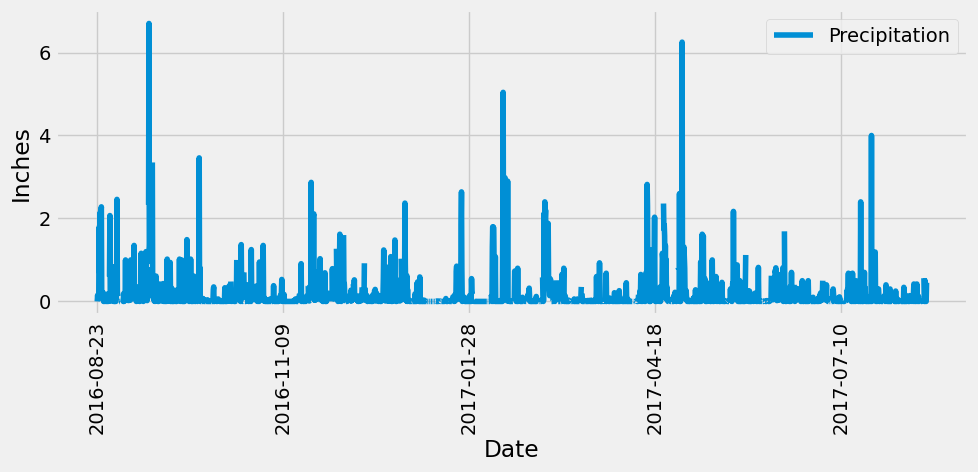

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
date = dt.datetime(2017, 8, 31)

# Calculate the date one year from the last date in data set.
one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago.strftime('%Y-%m-%d')).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])
prcp_df.set_index('date', inplace=True)
prcp_df

# Sort the dataframe by date
prcp_df = prcp_df.sort_values(by=['date'])

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 5))
prcp_df['precipitation'].plot(title='')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=90)
plt.legend(["Precipitation"])
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stat = prcp_df.describe()
summary_stat

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
# total_station = session.query[station].disctinct().count()
# total_station
station_total = [(session.query(func.count(Station.station)).scalar(),)]
station_total

[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_station = session.query(Measurement.station,
                                func.count(Measurement.id).label('measurement_count')) \
                         .group_by(Measurement.station) \
                         .order_by(func.count(Measurement.id).desc()) \
                         .all()
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
list_of_measurements = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
list_of_measurements
most_active_station_temp = session.query(*list_of_measurements)\
                        .group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).first()
most_active_station_temp

(54.0, 85.0, 71.66378066378067)

In [17]:
query_of_temp = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == active_station[0][0])\
                .filter(Measurement.date >= one_year_ago.strftime('%Y-%m-%d')).\
                order_by(Measurement.tobs).first()
query_of_temp

('2017-02-02', 59.0)

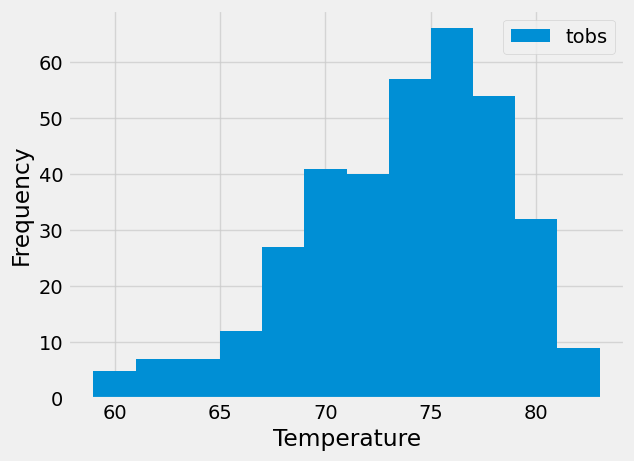

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_most_recent_date = dt.datetime(2017, 8, 18)

#calculating one year for the  most active station
one_year_data = pd.to_datetime(active_station_most_recent_date) - pd.DateOffset(years=1)

#create a list of temp for the
query_of_temp = session.query(Measurement.tobs).filter(Measurement.station == active_station[0][0])\
                .filter(Measurement.date >= one_year_data.strftime('%Y-%m-%d')).\
                order_by(Measurement.tobs).all()
query_of_temp
#convert tuples into a list so I can graph the histogram
temp_list = list(np.ravel(query_of_temp))
temp_list

len(temp_list)
#Plotting the results as a histogram
plt.hist(temp_list, bins=12, label= "tobs")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.grid(axis="both", alpha=.75)
plt.legend()

# Close Session

In [19]:
# Close Session
session.close()